# Part 3: Peer-to-peer Message Behaviour Data Analysis

---

### Install Python packages (pip only)

In [9]:
#e.g., %pip install some-package
%pip install networkx
%pip install matplotlib
%pip install numpy
%pip install scipy
%pip install pandas
%pip install operator
%pip install ndlib


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement operator (from versions: none)
ERROR: No matching distribution found for operator


Note: you may need to restart the kernel to use updated packages.


### Import Python packages

In [10]:
#e.g., import some-package
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import operator
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
%matplotlib inline 

---

### Task 1 of 2

Examine the file "p2p_msg_cmt224.csv" which represents messaging behaviour between users on a messaging platform. Each row has four columns, representing a single event where a person (person_a) messaged another person (person_b) on some date (date) at some time of day (time). From this, answer the following questions:

##### Q1. Build a suitable network to represent social connections based on the messaging behaviour that took place in the first 28 days. In doing so, assume that one or more messages from one person to another represents a mutual underlying social connection (i.e., regardless of whether person_a messaged person_b, person_b messaged person_a, or both at some point). 

Number of data within 28 days: 24592
Number of nodes: 1147
Number of edges: 6516


C:\Users\Winn_\AppData\Local\Temp\ipykernel_18548\2049754676.py:6: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'])


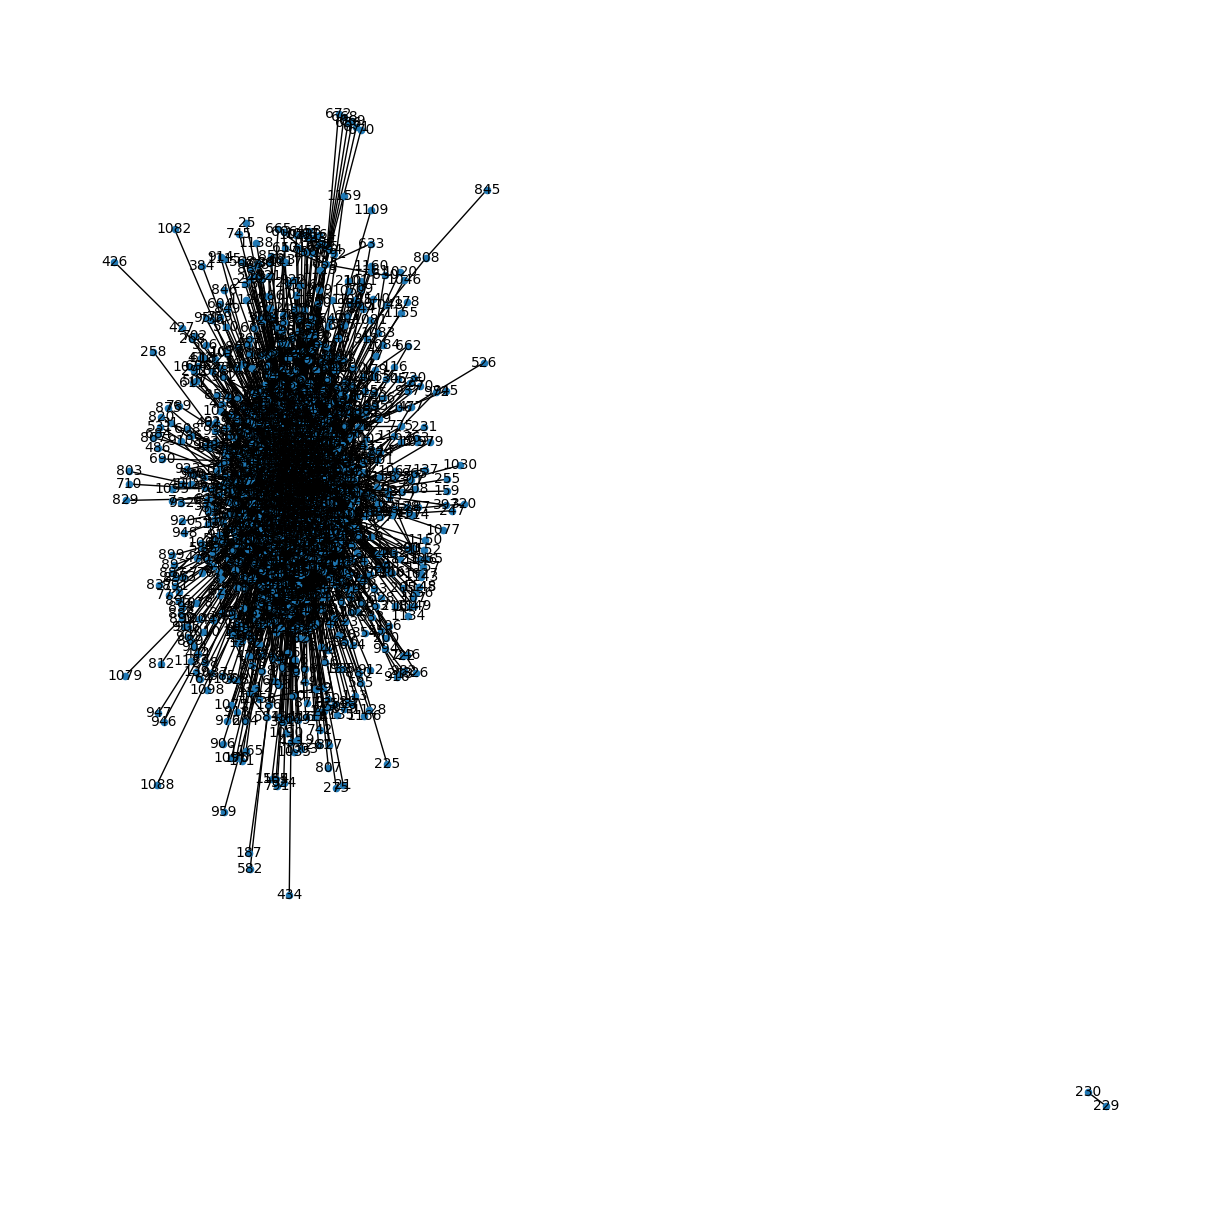

In [11]:
#CODE:
# 1 Read files and store information.
data_path = 'p2p_msg_cmt224.csv'
data = pd.read_csv(data_path)
# 2 Sort by time and date.
data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'])
data.sort_values('datetime', inplace=True)
# 3 Get the smallest time and date as a start point and get all data within 28 days.
start = data['datetime'].min()
end = start + pd.Timedelta(days=28)
data_in_range = data[(data['datetime'] >= start) & (data['datetime'] < end)]
print(f"Number of data within 28 days: {len(data_in_range)}")
# 4 Create an undirected graph of these data over a 28-day period.
G = nx.from_pandas_edgelist(data_in_range, 'person_a', 'person_b', create_using=nx.Graph())
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# 5 Visual network.
plt.figure(figsize=(12, 12))
nx.draw(G, with_labels=True, node_size=20, font_size=10)
plt.show()

##### Q2. Using the largest connected component of the network constructed in Task 1, Q1. What is the mean, median and the standard deviation of the differences between the maximum degree of separation of each individual and the average distance between the individual and all others?

In [12]:
#CODE:
# 1 Calculate the maximum connected components of the graph and create subgraphs.
largest_connected_component = max(nx.connected_components(G), key=len)
lcc_subgraph = G.subgraph(largest_connected_component)
# 2 For each node:
# (1) Maximum separation: calculates the shortest path length from this node to the farthest node.
# (2) Average distance: calculate the average path length for this node: the average path length from this node to all other nodes.
# (3) Calculate the difference and save it to the list.
differences = []
for node in lcc_subgraph.nodes():
    # Calculate the shortest path length from this node to all nodes.
    all_path_length = nx.single_source_shortest_path_length(lcc_subgraph, node)
    path_length_list = list(all_path_length.values())
    if all_path_length:
        max_sparation = np.max(path_length_list)
        average_distance = np.mean(path_length_list)
        differences.append(np.abs(max_sparation - average_distance))
# 3 Calculate the mean, median, and standard deviation of all data in the list.
mean_difference = np.mean(differences)
median_difference = np.median(differences)
std_difference = np.std(differences)
print(f"The mean of difference: {mean_difference:.2f}")
print(f"The median of difference: {median_difference:.2f}")
print(f"The standard deviation of difference: {std_difference:.2f}")

The mean of difference: 2.24
The median of difference: 2.23
The standard deviation of difference: 0.40


##### Q3. Build another suitable network to represent social connections based on ALL message behaviour in the dataset. In doing so, assume that one or messages from one person to another represents a MUTUAL underlying social connection (i.e., regardless of whether person_a messaged person_b, person_b messaged person_a, or both at some point).Can the social phenomenon, ‘Triadic Closure’, be supported for the common nodes that exist in both the network created from behaviour for the first 28 days (i.e., from Task 1, Q1) and the network built from all message behaviour?

In [13]:
#CODE:
# Build networks for full datasets.
G_full = nx.from_pandas_edgelist(data, 'person_a', 'person_b', create_using=nx.Graph())

# Find the common nodes of the two networks.
common_nodes = set(G.nodes()).intersection(set(G_full.nodes()))

# Create subgraphs using common nodes.
subgraph_28 = G.subgraph(common_nodes)
subgraph_full = G_full.subgraph(common_nodes)

# Calculate the triadic closure coefficients.
triadic_closure_28 = nx.transitivity(subgraph_28)
triadic_closure_full = nx.transitivity(subgraph_full)

# Print.
print(f"The triadic closure coefficients of the first 28 days network: {triadic_closure_28:.2f}")
print(f"The triadic closure coefficients of the full network: {triadic_closure_full:.2f}")

The triadic closure coefficients of the first 28 days network: 0.05
The triadic closure coefficients of the full network: 0.07


##### Q4. What hypothetical, non-existent edges would need to be added to the network representing all message behaviour (i.e., from Task 1, Q3) such that a message could pass along a path from any node to any other? In doing so, aim to minimise the number of edges that would be needed as well as the longest shortest path in the network as a result.

In [14]:
#CODE:
components = list(nx.connected_components(G_full))
subgraphs = [G_full.subgraph(c).copy() for c in components]

# Counting multiple centrality indices for each subgraph.
centrality_measures = []
for sg in subgraphs:
    centrality = {}
    centrality['betweenness'] = nx.betweenness_centrality(sg)
    centrality['closeness'] = nx.closeness_centrality(sg)
    centrality['degree_centrality'] = nx.degree_centrality(sg)
    centrality_measures.append(centrality)

# Select the representative node for each connected component.
rep_nodes = []
for idx, sg in enumerate(subgraphs):
    # Combining multiple centrality indices.
    combined_score = {node: centrality_measures[idx]['betweenness'][node] * 0.4 +
                             centrality_measures[idx]['closeness'][node] * 0.3 +
                             centrality_measures[idx]['degree_centrality'][node] * 0.3
                      for node in sg.nodes()}
    # Select the node with the highest combined score.
    best_node = max(combined_score, key=combined_score.get)
    rep_nodes.append(best_node)

# Connect these representative nodes, add edges.
new_edges = [(rep_nodes[i], rep_nodes[i+1]) for i in range(len(rep_nodes)-1)]
G_full.add_edges_from(new_edges)
print(f"The number of edges added: {len(new_edges)}")
print(f"Added edges: {new_edges}")

# Checking the connectivity of the new graph and trying to calculate the new diameter (longest shortest path length).
if nx.is_connected(G_full):
    print("The longest shortest path length after added edges:", nx.diameter(G_full))
else:
    print("Still not fully connected.")

The number of edges added: 5
Added edges: [(105, 229), (229, 1258), (1258, 1192), (1192, 1797), (1797, 1812)]
The longest shortest path length after added edges: 10


### Task 2 of 2 

Using the largest connected component of the network constructed from all data in Task 1, Q2, assume the role of an outsider with complete visibility of the network that now wishes to spread a hypothetical message such that everyone in the component would know the information it contained as quickly as possible. Assume that messages will now spread in sequential timesteps using the following mechanism. If an individual is told the message at timestep 𝑡, the individual will forward the message to all of their direct connections at timestep 𝑡+1. Individuals can therefore be told the message more than once. From this, answer the following questions:

##### Q1. If you could only select 1 individual to tell at timestep 0, what set of nodes could you select from which would result in the message being received by everyone in the fewest timesteps as possible and what would the number of timesteps be?

Select one individual that is told the information in timestep 0: 400


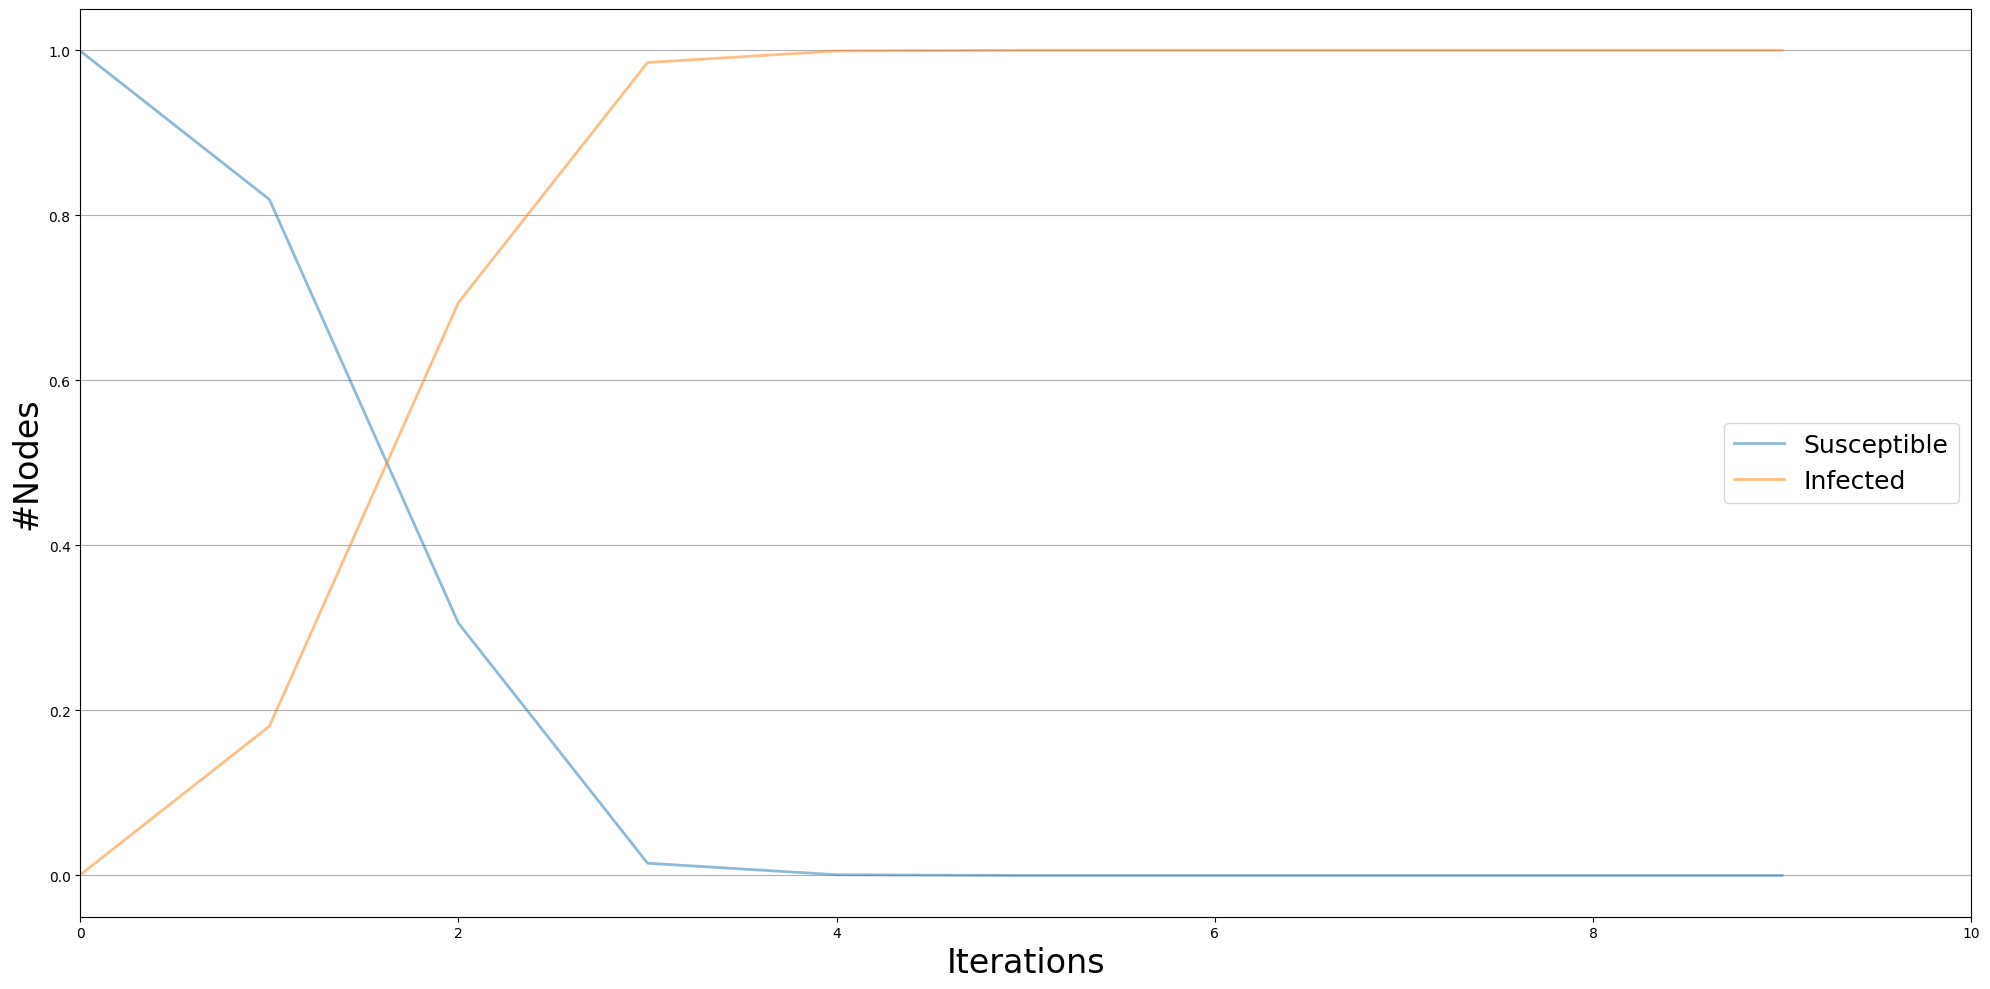

Iteration: 0    Number of people told the information: 1    Ratios: (0.0008733624454148472)
Iteration: 1    Number of people told the information: 207    Ratios: (0.18078602620087336)
Iteration: 2    Number of people told the information: 795    Ratios: (0.6943231441048034)
Iteration: 3    Number of people told the information: 1128    Ratios: (0.9851528384279477)
Iteration: 4    Number of people told the information: 1144    Ratios: (0.9991266375545852)
Iteration: 5    Number of people told the information: 1145    Ratios: (1.0)
The number of timesteps needed to tell the information to each person is: 5


In [15]:
#CODE:
# Define the diffusion model.
def diffusion_model(G, rate, iterations, initial_infected=None, fraction_infected=None, model_seed=1):
    # Diffusion model.
    model = ep.SIModel(G, seed=model_seed)

    # Configure the model.
    # Create model configuration items.
    model_configuration = mc.Configuration()
    # Setting the probability that a node will send information to its neighbours.
    model_configuration.add_model_parameter('beta', rate)
    # Perform n iterations on the model to simulate the spread and store the results.
    if initial_infected is not None:
        model_configuration.add_model_initial_configuration("Infected", initial_infected)
    else:
        model_configuration.add_model_parameter("fraction_infected", fraction_infected)
    model.set_initial_status(model_configuration)
    iterations = model.iteration_bunch(iterations)
    return model, iterations

# Model evaluation.
def evaluateModel(network, model, iterations, threshold):
    # Drawing diffusion lines.
    trends = model.build_trends(iterations)
    viz = DiffusionTrend(model, trends)
    viz.plot()
    # Print diffusion news.
    results = calculate_iterations_to_reach_threshold(
        trends,
        network.number_of_nodes(),
        threshold,
        True
    )
    print(f"The number of timesteps needed to tell the information to each person is: {results[0][1]}")

# Calculate and output the diffusion news.
def calculate_iterations_to_reach_threshold(trends, number_of_nodes, threshold, verbose=False):
    threshold_as_number_of_nodes = (number_of_nodes*threshold)
    iteration_counts_per_simulation = []
    for simulation in trends:
        number_infected_per_iteration = simulation["trends"]["node_count"][1]
        threshold_met = False
        iteration_count = 0
        for iteration, number_infected in enumerate(number_infected_per_iteration):
            if verbose:
                print(f"Iteration: {iteration}    Number of people told the information: {number_infected}    Ratios: ({(number_infected / number_of_nodes)})")
            if number_infected < threshold_as_number_of_nodes:
                iteration_count += 1
            else:
                threshold_met = True
                break
        iteration_counts_per_simulation.append((threshold_met, iteration_count))
    return iteration_counts_per_simulation

# Pick a node such that, starting from that node, use the shortest time to spread the information to all nodes in the network.
# Select the initial node based on the closeness centrality and create a sequence of closeness centrality from largest to smallest.
closeness_centrality = sorted(
    [(node[0], node[1]) for node in nx.closeness_centrality(lcc_subgraph).items()], 
    key=operator.itemgetter(1), 
    reverse=True
)

# Run the model.
# Configure model parameters.
network = lcc_subgraph
information_spreading_rate = 1
number_of_iterations = 10
# Select the node with the largest closeness centrality as the initial node.
initial_infected_node = [node[0] for node in closeness_centrality[:1]]
eva_threshold = 1.0

print(f"Select one individual that is told the information in timestep 0: {initial_infected_node[0]}")
model, interations = diffusion_model(
    network,
    information_spreading_rate,
    number_of_iterations,
    initial_infected=initial_infected_node
)
evaluateModel(
    network,
    model,
    interations,
    eva_threshold
)

##### Q2. If you had to select any 5 individuals to tell at timestep 0, can the message be received by everyone in fewer timesteps than the single individual selection in Q1? In determining your answer, use one or more appropriate network connectivity measures, rather than an exhaustive search through every combination of nodes in the network.

Select 5 individuals that are told the information in timestep 0: [400, 103, 32, 194, 41]


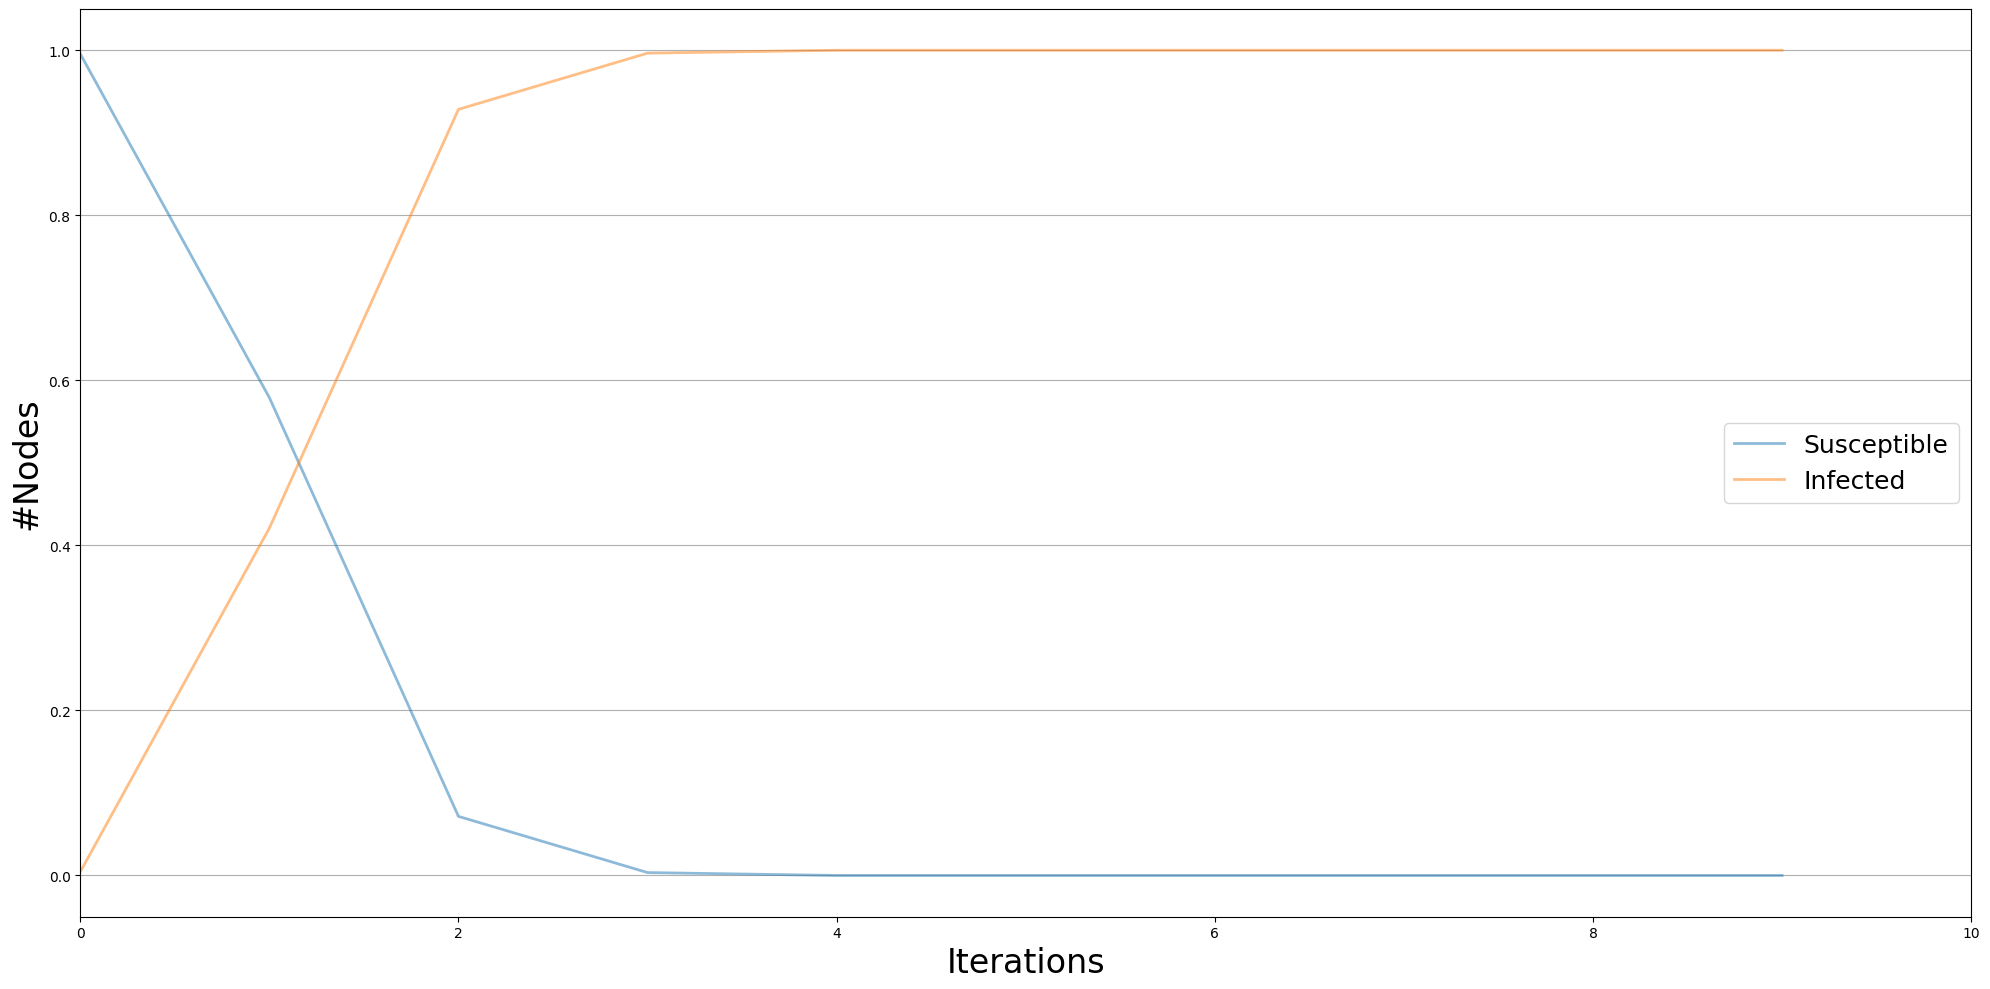

Iteration: 0    Number of people told the information: 5    Ratios: (0.004366812227074236)
Iteration: 1    Number of people told the information: 482    Ratios: (0.42096069868995634)
Iteration: 2    Number of people told the information: 1063    Ratios: (0.9283842794759826)
Iteration: 3    Number of people told the information: 1141    Ratios: (0.9965065502183406)
Iteration: 4    Number of people told the information: 1145    Ratios: (1.0)
The number of timesteps needed to tell the information to each person is: 4


In [16]:
#CODE:
# Choosing initial nodes based on closeness centrality and betweenness centrality.
betweenness_centrality = sorted(
    [(node[0], node[1]) for node in nx.betweenness_centrality(lcc_subgraph).items()],
    key=operator.itemgetter(1), 
    reverse=True
)
# This choice is due to avoiding repeated nodes.
initial_node_list = [node[0] for node in closeness_centrality[:3]] + [node[0] for node in closeness_centrality[4:6]]
print(f"Select 5 individuals that are told the information in timestep 0: {initial_node_list}")

# Set the initial parameters of the model.
network = lcc_subgraph
information_spreading_rate = 1
number_of_iterations = 10
initial_infected_node = initial_node_list
eva_threshold = 1.0
# Starting spreading.
model, interations = diffusion_model(
    network,
    information_spreading_rate,
    number_of_iterations,
    initial_infected=initial_infected_node
)
evaluateModel(
    network,
    model,
    interations,
    eva_threshold
)